## X-Ray Abnormality Detection with CNNs

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Baseline Performance](#Baseline-Performance)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [1]:
# TODO: remove
# !pip install scipy
# !pip install git+https://github.com/keras-team/keras-tuner

In [2]:
import gc
import itertools
import os
import pathlib
import random
import re
from glob import glob

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from plotnine import *
from sklearn.metrics import confusion_matrix


pd.set_option("max_colwidth", None)
# from scipy import optimize  # TODO: remove

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-03-17 22:08:52.088657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:08:52.106763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:08:52.106922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
SEED = 123456

random.seed(SEED)

In [5]:
print(tf.__version__)

2.8.0


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [7]:
if not os.path.exists("data/augmented"):  # to be able to inspect image augmentation
    os.makedirs("data/augmented")

### Data Loading

In [8]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [9]:
DATASET_DIR = "data/MURA-v1.1/"

In [10]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['data/MURA-v1.1/train/XR_WRIST/patient08677/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_WRIST/patient08822/study1_negative/image3.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient05309/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_FINGER/patient04573/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient05276/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_FOREARM/patient09254/study1_positive/image2.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient03454/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_HAND/patient07839/study1_negative/image2.png',
 'data/MURA-v1.1/train/XR_ELBOW/patient06081/study1_negative/image1.png',
 'data/MURA-v1.1/train/XR_FINGER/patient03997/study1_negative/image1.png']

In [11]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <data/MURA-v1.1/>: 40009


In [12]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [13]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [14]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [15]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [16]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [17]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [18]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a Tensorflow input pipeline for the training data

In [19]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.2,
)

In [20]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    save_to_dir="data/augmented",
    subset="training",
)

Found 29447 validated image filenames belonging to 2 classes.


In [21]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    save_to_dir="data/augmented",
    subset="validation",
)

Found 7361 validated image filenames belonging to 2 classes.


#### Create a Tensorflow input pipeline for the testing data

In [22]:
test_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

In [23]:
test_image_paths["image_path"] = test_image_paths["image_path"].map(
    lambda x: os.path.join("data/", x)
)
test_image_paths["study_type"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[3]
)
test_image_paths["patient"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
test_image_paths["study"] = test_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
test_image_paths["study_path"] = test_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [24]:
test_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "valid_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

In [25]:
test_labeled_studies["study_path"] = test_labeled_studies["study_path"].map(
    lambda x: os.path.join("data/", x)
)
test_labeled_studies["label"] = test_labeled_studies["label"].map(str)

In [26]:
ref_testset = pd.merge(
    test_image_paths, test_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_testset)

shape: (3197, 6)


,image_path,study_type,patient,study,study_path,label
0,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
1,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
2,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
3,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image4.png,XR_WRIST,patient11185,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1
4,data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/image1.png,XR_WRIST,patient11186,study1_positive,data/MURA-v1.1/valid/XR_WRIST/patient11186/study1_positive/,1


In [27]:
testing = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
)

In [28]:
testset = testing.flow_from_dataframe(
    dataframe=ref_testset,
    x_col="image_path",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    save_to_dir="data/augmented",
)

Found 3197 validated image filenames belonging to 2 classes.


### Exploratory Data Analysis

Each study contains one or more views (images) and is labeled as either normal or abnormal.

The training dataset consists of `13456` studies with a total of `36807` images.

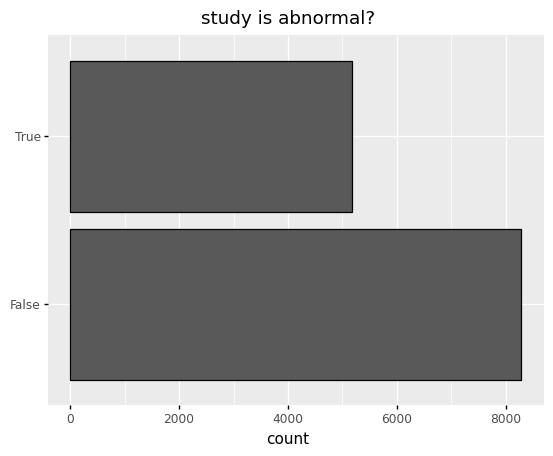

<ggplot: (8733886780636)>

In [29]:
abnormal = train_labeled_studies["label"] == "1"

(
    ggplot()
    + geom_bar(mapping=aes(x=abnormal), colour="black")
    + labs(title="study is abnormal?", x="")
    + coord_flip()
)

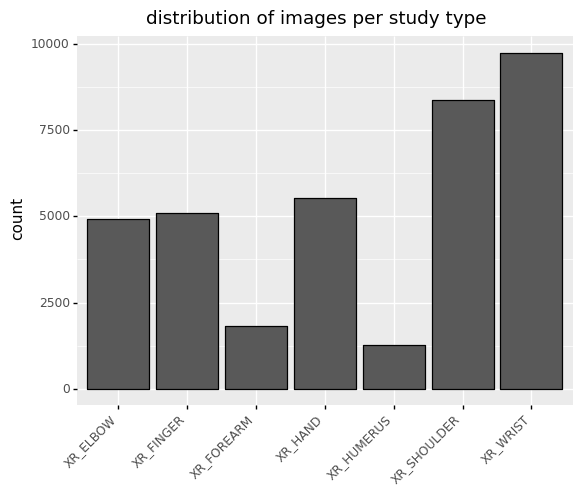

<ggplot: (8733886779025)>

In [30]:
(
    ggplot(train_image_paths)
    + geom_bar(aes(x="study_type"), colour="black")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + labs(x="", y="count", title="distribution of images per study type")
)

### Baseline Performance

In [31]:
def clean_up(model_):
    tf.keras.backend.clear_session()
    del model_
    gc.collect()

In [32]:
tf.keras.backend.clear_session()

In [33]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.AUC(name="prc", curve="PR"),  # precision-recall curve
]

2022-03-17 22:08:53.995124: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 22:08:53.995906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:08:53.996139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 22:08:53.996270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_prc",
    verbose=1,
    patience=10,
    mode="max",
)

In [35]:
def plot_metrics(history):

    plt.rcParams["figure.figsize"] = (12, 10)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    metrics = ["loss", "prc", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[0],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend();

In [36]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.PuBuGn
):

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = [11, 9]
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [37]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(128, 128, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.2,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.2,
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [38]:
model = make_cnn_model()

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 128, 128, 64)      1792      
                                                                 
 1st-max-pooling (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 64, 64, 64)        0         
                                                                 
 2nd-convolution (Conv2D)    (None, 64, 64, 32)        18464     
                                                                 
 2nd-max-pooling (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 2nd-dropout (Dropout)       (None, 32, 32, 32)        0

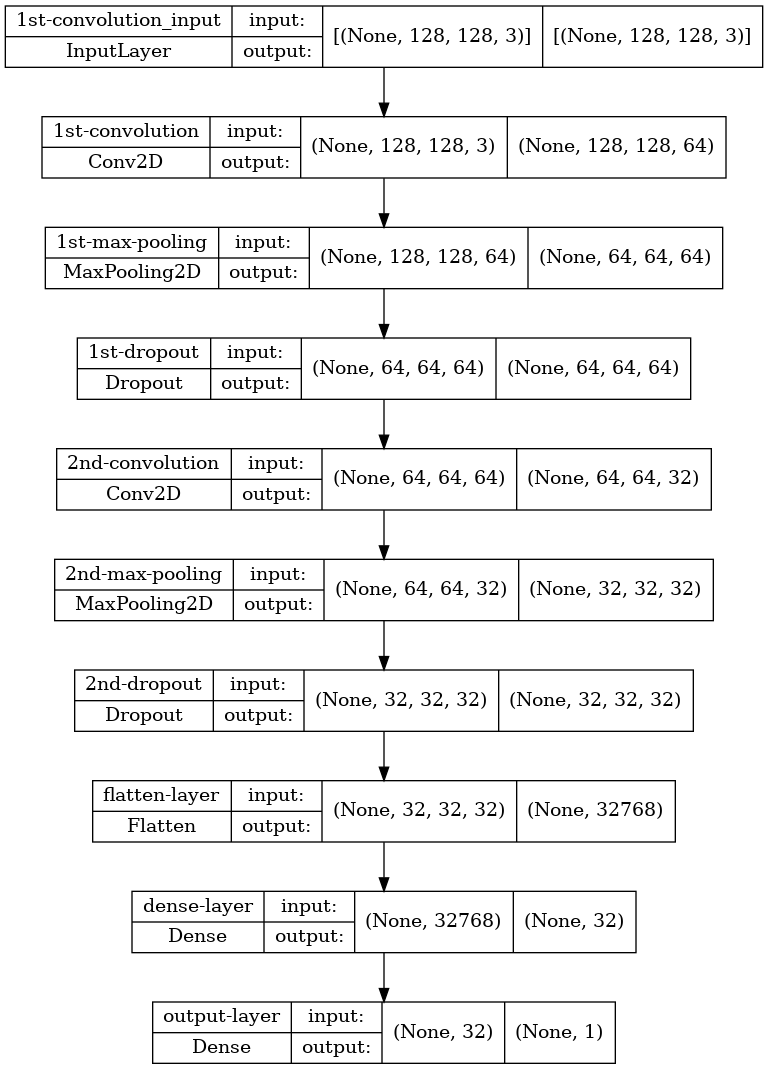

In [40]:
tf.keras.utils.plot_model(
    model,
    to_file="static/cnn_baseline_model.png",
    show_shapes=True,
    show_layer_names=True,
)

In [41]:
history = model.fit(
    trainset, epochs=100, validation_data=validationset, callbacks=[early_stopping]
)

Epoch 1/2


2022-03-17 22:08:56.807917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


133/921 [===>..........................] - ETA: 2:44 - loss: 1.4481 - tp: 14.0000 - fp: 21.0000 - tn: 2678.0000 - fn: 1543.0000 - accuracy: 0.6325 - precision: 0.4000 - recall: 0.0090 - auc: 0.5129 - prc: 0.3652

KeyboardInterrupt: 

In [ ]:
plot_metrics(history)

In [ ]:
metrics = model.evaluate(testset, verbose=1)

In [ ]:
loss = metrics.pop(0)

In [ ]:
print(f"test loss: {loss}")
for metric, score in zip(METRICS, metrics):

    print(f"{metric.name}: {score}")

In [ ]:
Y_pred = model.predict(testset, verbose=1)

In [ ]:
Y_pred_classes = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(testset.labels, Y_pred_classes)

In [ ]:
plot_confusion_matrix(
    confusion_mtx,
    classes=["normal", "abnormal"],
)

In [ ]:
clean_up(model)

### Hyperparameter Tuning

In [ ]:
def cnn_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=hp.Int("1st-filter", min_value=32, max_value=128, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(128, 128, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("1st-dropout", min_value=0.0, max_value=0.4, step=0.1),
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=hp.Int("2nd-filter", min_value=32, max_value=64, step=16),
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=hp.Float("2nd-dropout", min_value=0.0, max_value=0.4, step=0.1),
                name="2nd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=hp.Int("dense-layer-units", min_value=32, max_value=128, step=16),
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice(
                "learning-rate", values=[1e-3, 1e-4, 2 * 1e-4, 4 * 1e-4]
            )
        ),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [ ]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    cnn_model_builder,
    objective=kt.Objective("val_prc", direction="max"),
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="cnn",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(
    trainset,
    validation_data=validationset,
    epochs=50,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping],
)

# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of output filters in the 1st convolution : {best_hps.get('1st-filter')}
|
---- optimal first dropout rate                              : {best_hps.get('1st-dropout')}
|
---- optimal number of output filters in the 2nd convolution : {best_hps.get('2nd-filter')}
|
---- optimal second dropout rate                             : {best_hps.get('2nd-dropout')}
|
---- optimal number of units in the densely-connected layer  : {best_hps.get('dense-layer-units')}
|
---- optimal learning rate for the optimizer                 : {best_hps.get('learning-rate')}
"""
)

### Model Selection

In [ ]:
model = tuner.get_best_models(num_models=1)[0]

model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model, to_file="static/cnn_best_model.png", show_shapes=True, show_layer_names=True
)

In [ ]:
clean_up(model)

In [ ]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(
    trainset, epochs=50, validation_data=validationset, callbacks=[early_stopping]
)

In [ ]:
# keep best epoch
val_prc_per_epoch = history.history["val_prc"]
best_epoch = val_prc_per_epoch.index(max(val_prc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

In [ ]:
clean_up(hypermodel)

In [ ]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(
    trainset,
    epochs=best_epoch,
    validation_data=validationset,
    callbacks=[early_stopping],
)

### Evaluation

In [ ]:
metrics = hypermodel.evaluate(testset, verbose=1)

In [ ]:
loss = metrics.pop(0)

print(f"test loss: {loss}")
for metric, score in zip(METRICS, metrics):

    print(f"{metric.name}: {score}")

In [ ]:
Y_pred = model.predict(testset, verbose=1)

In [ ]:
Y_pred_classes = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(testset.labels, Y_pred_classes)

In [ ]:
plot_confusion_matrix(
    confusion_mtx,
    classes=["normal", "abnormal"],
)